In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rc('font', size=20)

In [2]:
from abc import abstractmethod

In [3]:
class AntiderivativeNum:
    
    def __init__(self, f, N, a = 0., alpha = None, t = None, name = 'Произвольная разностная схема'):
        self.f = f
        self.a = a
        self.name = name
        self.N = N
        self.alpha = alpha
        self.t = t
        self.h = None
        
    def setAlpha(self):
        self.alpha = self.h * np.ones(self.N + 1)
    
    def setAlphaAndGrid(self):
        self.t = [(self.a + i * self.h) for i in range(self.N + 1)]
        if self.alpha == None:
            self.setAlpha()
        
    def __call__(self, x):
        self.h = (float(x) - self.a) / self.N
        #print(type(self.a))
        self.setAlphaAndGrid()
        return np.dot(self.alpha, [(self.f(tt)) for tt in self.t])

In [4]:
class AntiderivativeSimpson(AntiderivativeNum):
    def __init__(self, f, N, a = 0, alpha = None, t = None, name = 'Симпсон'):
        AntiderivativeNum.__init__(self, f, N, a, alpha, t, name)
        
    def setAlpha(self):
        m = int(np.floor(self.N / 2))
        self.alpha = []
        for i in range(self.N + 1):
            if i % 2 == 0:
                self.alpha.append(2 * self.h / 3)
            else:
                self.alpha.append(4 * self.h / 3)
        self.alpha[0] = self.h / 3
        self.alpha[m * 2] = self.h / 3

In [5]:
class FEMMesh:
    
    def __init__(self, xL, xR, numFEs):
        # равноотстоящие узлы
        self.numFEs = numFEs
        self.nodes = list(np.linspace(xL, xR, numFEs + 1))
        self.finiteElems = [ [self.nodes[i], self.nodes[i + 1]] \
                             for i in range(len(self.nodes) - 1)] 
        self.h = float(np.diff(self.nodes)[0])
    
    
    def __str__(self):
        counter = 0
        for elem in self.finiteElems:
            print('Elem #%d: [%.2f, %.2f]' % (counter, elem.xL, elem.xR))
            counter += 1

In [6]:
class BasisFunction:
    
    # индекс "i" базисной функции: 1 <= i <= numNodes - 2
    def __init__(self, mesh, index):
        self.mesh = mesh
        self.i = index # "i" --- параметр
    
    def __call__(self, x):
        xArrayMesh = self.mesh.nodes # для краткости
        i = self.i # для краткости
        
        # функция-"шапка"
        if i != 0 and i != len(xArrayMesh) - 1:
            if x >= xArrayMesh[i - 1] and x < xArrayMesh[i]:
                return (x - xArrayMesh[i - 1]) / self.mesh.h
            elif x >= xArrayMesh[i] and x < xArrayMesh[i + 1]:
                return 1. - (x - xArrayMesh[i]) / self.mesh.h
            else:
                return 0.
            

        # левая функция-"полушапка"
        elif i == 0:
            if x >= xArrayMesh[0] and x < xArrayMesh[1]:
                return 1. - (x - xArrayMesh[i]) / self.mesh.h
            else: 
                return 0.
        
        
        # правая функция-"полушапка"
        elif i == len(xArrayMesh) - 1:
            if x > xArrayMesh[-2] and x <= xArrayMesh[-1]:
                return (x - xArrayMesh[-2]) / self.mesh.h
            else: 
                return 0.
            
    
    def Plot(self):
        xL = self.mesh.nodes[0]
        xR = self.mesh.nodes[-1]
        
        xData = np.linspace(xL, xR, 100)
        yData = np.array([self(x) for x in xData])
        
        plt.figure(figsize=(11, 6))
        plt.plot(xData, yData, '-', lw=2)
        plt.grid(None)
        plt.show()

In [7]:
class FEMSolver:

    def __init__(self, mesh, function, points):
        self.mesh = mesh
        self.f = function
        self.numNodes = len(self.mesh.nodes)
        
        self.BasisFuncs = [BasisFunction(self.mesh, i) \
                            for i in range(0, self.numNodes)]
        
        
        # поля, свойственные методу регрессии
        #self.regressionPoints = points
        self.points = points
               
    def _SetupLinearSystem(self):
        self.M = np.zeros((self.numNodes, self.numNodes))
        self.b = [self._LoadVectorEntry(i) for i in range(self.numNodes)]
        
        for i in range(self.M.shape[0]):
            self.M[i, :] = self._MassMatrixEntry(i)
        
    @abstractmethod
    def _MassMatrixEntry(self, i):
        pass
        
    @abstractmethod
    def _LoadVectorEntry(self, i):
        pass
        
    def Solve(self):
        self._SetupLinearSystem()
        self.c = np.linalg.solve(self.M, self.b)
    
    def EvaluateSolution(self, x):
        return np.sum([(coeff*BasisFunc(x)) for coeff, BasisFunc in zip(self.c, self.BasisFuncs)])
    
    def PlotSolution(self):
        xL = self.mesh.nodes[0]
        xR = self.mesh.nodes[-1]
        
        self.xData = np.linspace(xL, xR, 100)
        yData = np.array([self.EvaluateSolution(x) for x in self.xData])
        
        #plt.figure(figsize=(11, 6))
        plt.plot(self.xData, yData, '-', lw=2, label=self.__class__.__name__)
        plt.legend()
        plt.grid(None)
        #plt.show()

In [8]:
class FEMSolverLeastSquareMethod(FEMSolver):
    
    def integrate(self, g):
        aN = AntiderivativeSimpson(g, 1000, a = self.mesh.nodes[0])
        return aN(self.mesh.nodes[-1])
    
    def _MassMatrixEntry(self, i):
        multBasBas = lambda x: (self.BasisFuncs[i](x) * self.BasisFuncs[j](x))
        Mi = np.zeros(self.numNodes)
        j = i
        Mi[i] = self.integrate(multBasBas)
        if (i != 0):
            j = i - 1
            Mi[i - 1] = self.integrate(multBasBas)
        if (i != (self.numNodes - 1)):
            j = i + 1
            Mi[i + 1] = self.integrate(multBasBas)
        return Mi
    
    def _LoadVectorEntry(self, i):
        multFBas = lambda x: (self.f(x) * self.BasisFuncs[i](x))
        return self.integrate(multFBas)

In [9]:
class FEMSolverInterpolation(FEMSolver):

    def _MassMatrixEntry(self, i):
        return [(self.BasisFuncs[j](self.mesh.nodes[i])) for j in range(self.numNodes)]
        
    def _LoadVectorEntry(self, i):
        return self.f(self.mesh.nodes[i])

In [10]:
class FEMSolverRegression(FEMSolver):
    
    def _MassMatrixEntryij(self, i, j):
        points = self.points
        return np.sum([(self.BasisFuncs[i](points[k])*self.BasisFuncs[j](points[k])) for k in range(len(points))]) 
    
    def _MassMatrixEntry(self, i):
        return [(self._MassMatrixEntryij(i, j)) for j in range(self.numNodes)]
    
    def _LoadVectorEntry(self, i):
        points = self.points
        return np.sum([(self.BasisFuncs[i](points[k])*self.f(points[k])) for k in range(len(points))])

In [11]:
class SolverPair:
    
    def __init__(self, methodClass, points):
        self.methodClass = methodClass
        self.points = points

In [12]:
func = lambda t: 1. + (t**2)*np.sin(2.*np.pi*t)

xL_, xR_ = 0., 1.
mesh = FEMMesh(xL=xL_, xR=xR_, numFEs=5)
points = [None, np.linspace(xL_, xR_, 5), np.linspace(xL_, xR_, 7)]

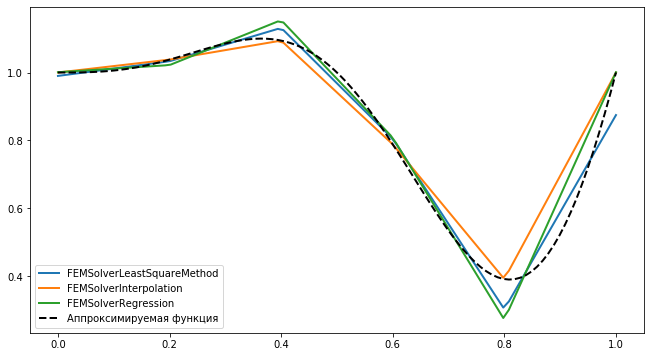

In [13]:
solvers = [SolverPair(FEMSolverLeastSquareMethod, points[0]), SolverPair(FEMSolverInterpolation, points[1]), SolverPair(FEMSolverRegression, points[2])]

plt.figure(figsize=(11, 6))
for solverClass in solvers:
    solver = solverClass.methodClass(mesh, func, solverClass.points)
    solver.Solve()
    solver.PlotSolution()

# график аппроксимируемой функции
plt.plot(solver.xData, func(solver.xData), 'k--', label='Аппроксимируемая функция', lw=2)
plt.legend(loc='best')
plt.grid(None)
plt.show()

FEMSolverLeastSquareMethod FEMSolverInterpolation


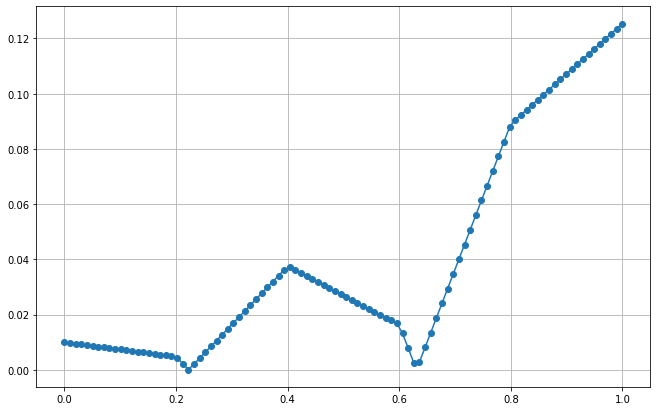

FEMSolverLeastSquareMethod FEMSolverRegression


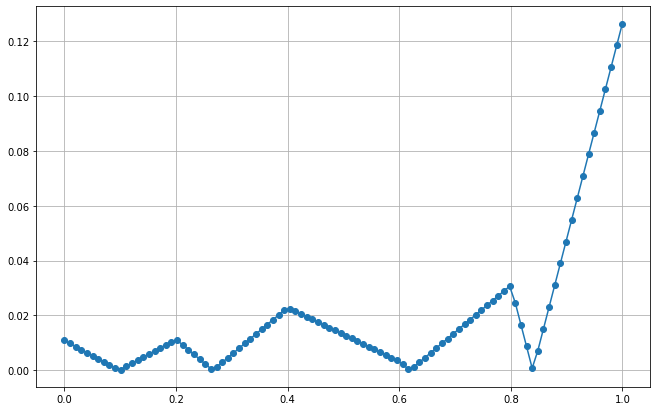

FEMSolverInterpolation FEMSolverLeastSquareMethod


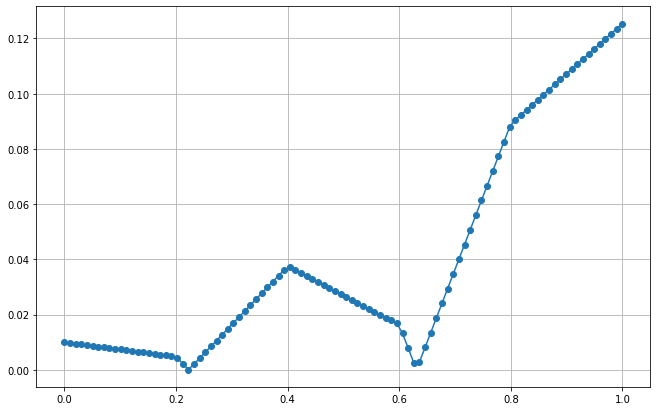

FEMSolverInterpolation FEMSolverRegression


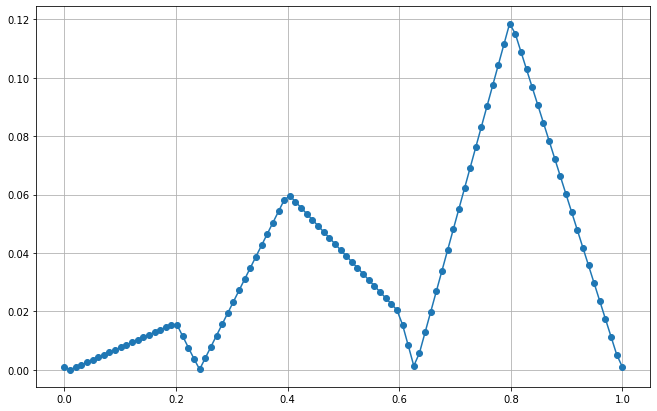

FEMSolverRegression FEMSolverLeastSquareMethod


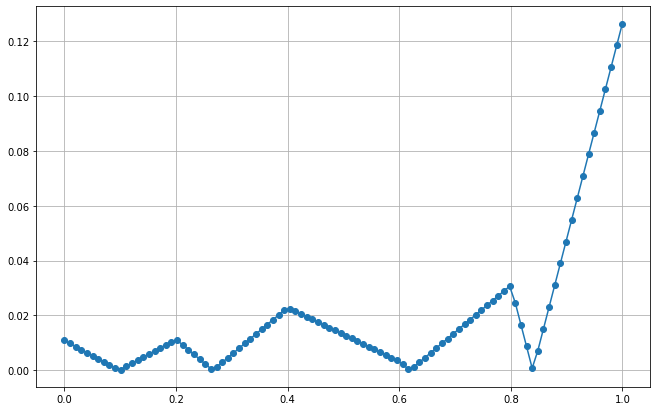

FEMSolverRegression FEMSolverInterpolation


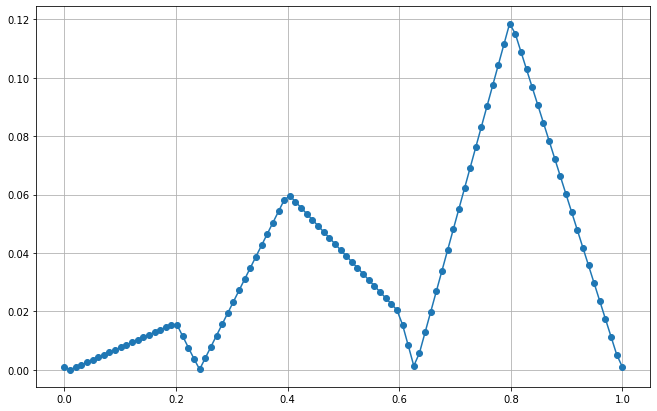

In [14]:
xData = np.linspace(xL_, xR_, 100)
for solver1 in solvers:
    for solver2 in solvers:
        if(solver1 != solver2):
            s1 = solver1.methodClass(mesh, func, solver1.points)
            s2 = solver2.methodClass(mesh, func, solver2.points)
            s1.Solve()
            s2.Solve()
            yData1 = np.array([s1.EvaluateSolution(x) for x in xData])
            yData2 = np.array([s2.EvaluateSolution(x) for x in xData])
            delta = np.fabs(yData1 - yData2)
            plt.figure(figsize=(11,7))
            print(s1.__class__.__name__, s2.__class__.__name__)
            #plt.title('%s ' % s1.__class__.__name__, " и %s " % s2.__class__.__name__)
            plt.plot(xData, delta, '-o')
            plt.grid('off')
            plt.show()

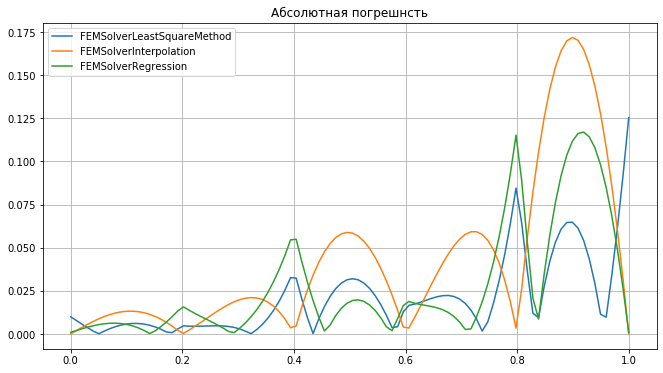

In [15]:
xData = np.linspace(xL_, xR_, 100)
plt.figure(figsize=(11, 6))
plt.title('Абсолютная погрешнсть')
for solverClass in solvers:
    solver = solverClass.methodClass(mesh, func, solverClass.points)
    solver.Solve()
    yData = np.array([solver.EvaluateSolution(x) for x in xData])
    delta = np.fabs(yData - func(xData))
    plt.plot(xData, delta, label=solver.__class__.__name__)
plt.legend()
plt.grid('off')
plt.show()

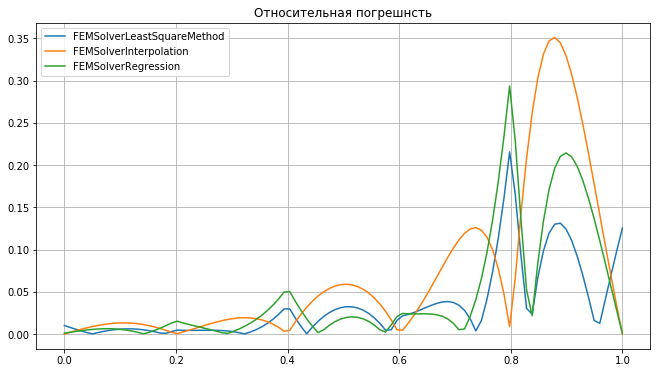

In [16]:
xData = np.linspace(xL_, xR_, 100)
plt.figure(figsize=(11, 6))
plt.title('Относительная погрешнсть')
for solverClass in solvers:
    solver = solverClass.methodClass(mesh, func, solverClass.points)
    solver.Solve()
    yData = np.array([solver.EvaluateSolution(x) for x in xData])
    ff = func(xData)
    delta = np.fabs((yData - ff) / ff)
    plt.plot(xData, delta, label=solver.__class__.__name__)
plt.legend()
plt.grid('off')
plt.show()